# Exploratory Data Analysis on Chicago Crime data
by *Harsh Vardhan Pachisia*

## Setting up PySpark environment and Data Ingestion

Printing configuration settings

In [1]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [2]:
sc.install_pypi_package("matplotlib==3.2.1", "https://pypi.org/simple")
sc.install_pypi_package("pandas==1.0.5", "https://pypi.org/simple")
sc.install_pypi_package("scipy==1.4.1", "https://pypi.org/simple")
sc.install_pypi_package("seaborn==0.11.2", "https://pypi.org/simple")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1716504187234_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.functions import year, month
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
#create a Spark application
spark = SparkSession.builder.appName('crimes_eda').getOrCreate()
spark

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
spark.sparkContext.uiWebUrl

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'http://ip-172-31-7-124.ec2.internal:4040'

In [6]:
#print spark configuration settings
spark.sparkContext.getConf().getAll()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[('spark.eventLog.enabled', 'true'), ('spark.executor.memory', '9486M'), ('spark.jars', 'file:/usr/lib/livy/rsc-jars/livy-api-0.7.0-incubating.jar,file:/usr/lib/livy/rsc-jars/livy-rsc-0.7.0-incubating.jar,file:/usr/lib/livy/rsc-jars/livy-thriftserver-session-0.7.0-incubating.jar,file:/usr/lib/livy/rsc-jars/netty-all-4.1.17.Final.jar,file:/usr/lib/livy/repl_2.12-jars/commons-codec-1.9.jar,file:/usr/lib/livy/repl_2.12-jars/livy-core_2.12-0.7.0-incubating.jar,file:/usr/lib/livy/repl_2.12-jars/livy-repl_2.12-0.7.0-incubating.jar'), ('spark.yarn.dist.jars', 'file:///usr/lib/livy/rsc-jars/livy-api-0.7.0-incubating.jar,file:///usr/lib/livy/rsc-jars/livy-rsc-0.7.0-incubating.jar,file:///usr/lib/livy/rsc-jars/livy-thriftserver-session-0.7.0-incubating.jar,file:///usr/lib/livy/rsc-jars/netty-all-4.1.17.Final.jar,file:///usr/lib/livy/repl_2.12-jars/commons-codec-1.9.jar,file:///usr/lib/livy/repl_2.12-jars/livy-core_2.12-0.7.0-incubating.jar,file:///usr/lib/livy/repl_2.12-jars/livy-repl_2.12-0.7.0

In [7]:
sc = spark.sparkContext

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Read the Chicago crimes dataset into a PySpark dataframe

In [8]:
crimes = spark.read \
    .option("quote", "\"")  \
    .option("escape", "\"") \
    .option("ignoreLeadingWhiteSpace",True) \
    .csv("s3://hvpachisia-chicago-crime/raw_data/crimes.csv",inferSchema=True, header=True )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
crimes.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)

In [10]:
%matplotlib inline

Summary statistics

In [60]:
#summary statistics
crimes.describe().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------------------+------------------+------------------+------------------+-----------------+---------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+--------------------+--------------------+-----------------+--------------+------------------+------------------+-------------------+------------------+----------------------+------------------+------------------+
|summary|    community_area|                ID|       Case Number|             Block|              IUCR|     Primary Type|    Description|Location Description|              Beat|          District|              Ward|         FBI Code|      X Coordinate|      Y Coordinate|             Year|          Latitude|           Longitude|            Location|            Month|community_name|        Birth Rate|Assault (Homicide)|Below Poverty Level|   Crowded Housing|No High School D

Inspecting the data partitions and repartitioning if needed

In [61]:
#display number of records by partition
crimes.rdd.getNumPartitions()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

15

In [62]:
#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [63]:
displaypartitions(crimes)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Partitions: 15
+-----------+------+
|partitionId| count|
+-----------+------+
|         14|103303|
|          0|198698|
|          1|348340|
|         13|561414|
|         12|563859|
|         11|565018|
|         10|565442|
|          9|566176|
|          8|566582|
|          4|567334|
|          3|567434|
|          5|567499|
|          7|567910|
|          2|568734|
|          6|569259|
+-----------+------+

I don't think there is a need to repartition the data since the data is already being shared relatively equally between each partition and the number of records in each partition is not so high that it would exceed the thresholds. 

## Data Cleaning

Drop the columns I know I won't use

In [11]:
crimes = crimes.drop("Updated On")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
# seeing if the columns got dropped
crimes.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Year', 'Latitude', 'Longitude', 'Location']

Note: **I am not dropping crimes which have null values** in any of the columns. Even though I am sure there are a lot of them, those crimes should still be counted (with whatever information is available) in the analysis, since each crime should be kept.

In [ ]:
# getting a sample of the data
crimes.show(5, truncate=False)

Discussion about each column data type:

ID: int, Case number: String (leaving as string since contains both letters and numbers), Date: Convert to datetime/timestamp, Block: leave as string, IUCR: Convert to int, Primary Type: String, Descriptiion: String, Location Description: String, Arrest: boolean, Domestic: Boolean, District: Int, Community area- int, location: leave as string

In [13]:
# Convert 'Date' and 'Updated On' columns to timestamp
crimes = crimes.withColumn("Date", F.to_timestamp(F.col("Date"), "MM/dd/yyyy hh:mm:ss a"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
from pyspark.sql.functions import col, count
crimes.select([count(F.when(col(c).isNull(), c)).alias(c) for c in crimes.columns]).show()

In [14]:
# adding month column
crimes = crimes.withColumn("Month", F.month(col("Date")))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Adding in community level data (community_name)

In [15]:
communities = spark.read \
    .option("quote", "\"")  \
    .option("escape", "\"") \
    .option("ignoreLeadingWhiteSpace",True) \
    .csv("s3://hvpachisia-chicago-crime/raw_data/communities.csv",inferSchema=True, header=True )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
communities.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- community_number: integer (nullable = true)
 |-- community_name: string (nullable = true)

In [17]:
# adding community_name as a column to crimes
crimes = crimes.join(communities, crimes["Community Area"] == communities["community_number"], "left")
#dropping community_number as no longer needed
crimes = crimes.drop("community_number")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
crimes.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- community_name: string (nullable = true)

## Explore data by crime attributes



Number of crimes per year

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

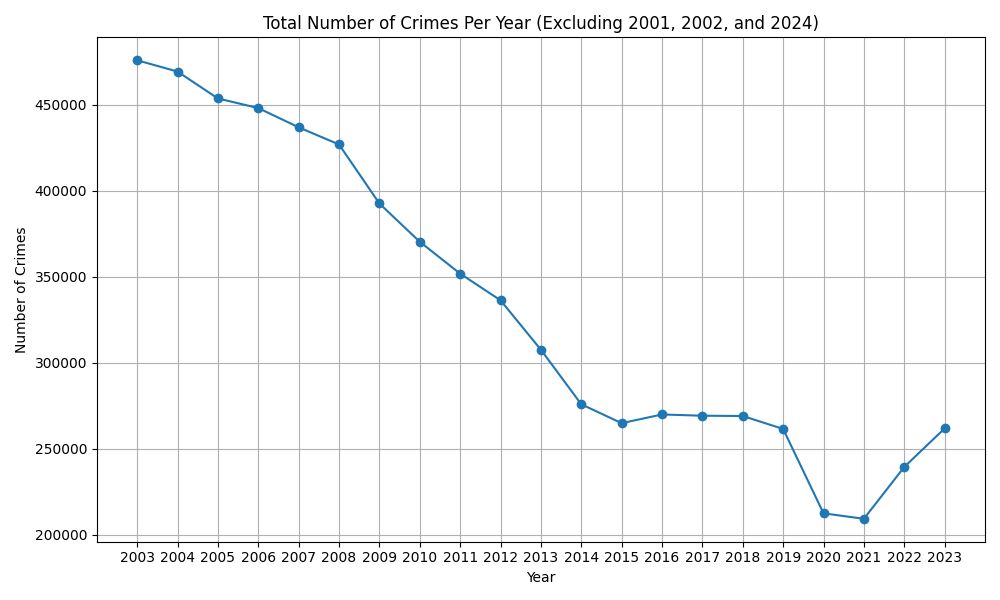

In [70]:
crimes_per_year = crimes.groupBy("Year").count().orderBy("Year").filter(~crimes["Year"].isin([2001, 2002, 2024]))

crimes_per_year = crimes_per_year.withColumn("Year", crimes_per_year["Year"].cast("integer"))

crimes_per_year_pd = crimes_per_year.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(crimes_per_year_pd["Year"], crimes_per_year_pd["count"], marker='o')
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.title("Total Number of Crimes Per Year (Excluding 2001, 2002, and 2024)")
plt.grid(True)
plt.xticks(crimes_per_year_pd["Year"])  # Ensure the x-ticks are set to the years
plt.tight_layout()

%matplot plt

Crime seems to steadily going down over time. I excluded 2001 and 2002 since the lack of crimes then are more indicative of poor data collection. I also removed 2024 since we haven't had the entire year yet. It did decrease drastically during COVID-19 pandemic. 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

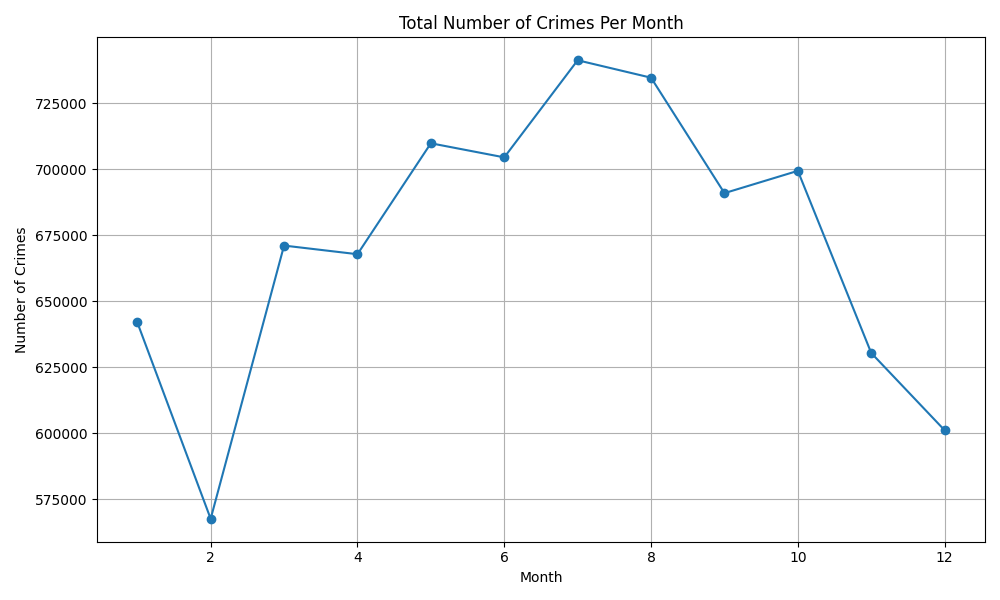

In [34]:
crimes_per_month = crimes.groupBy("Month").count().orderBy("Month")

crimes_per_month_pd = crimes_per_month.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(crimes_per_month_pd["Month"], crimes_per_month_pd["count"], marker='o')
plt.xlabel("Month")
plt.ylabel("Number of Crimes")
plt.title("Total Number of Crimes Per Month")
plt.grid(True)
plt.tight_layout()

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

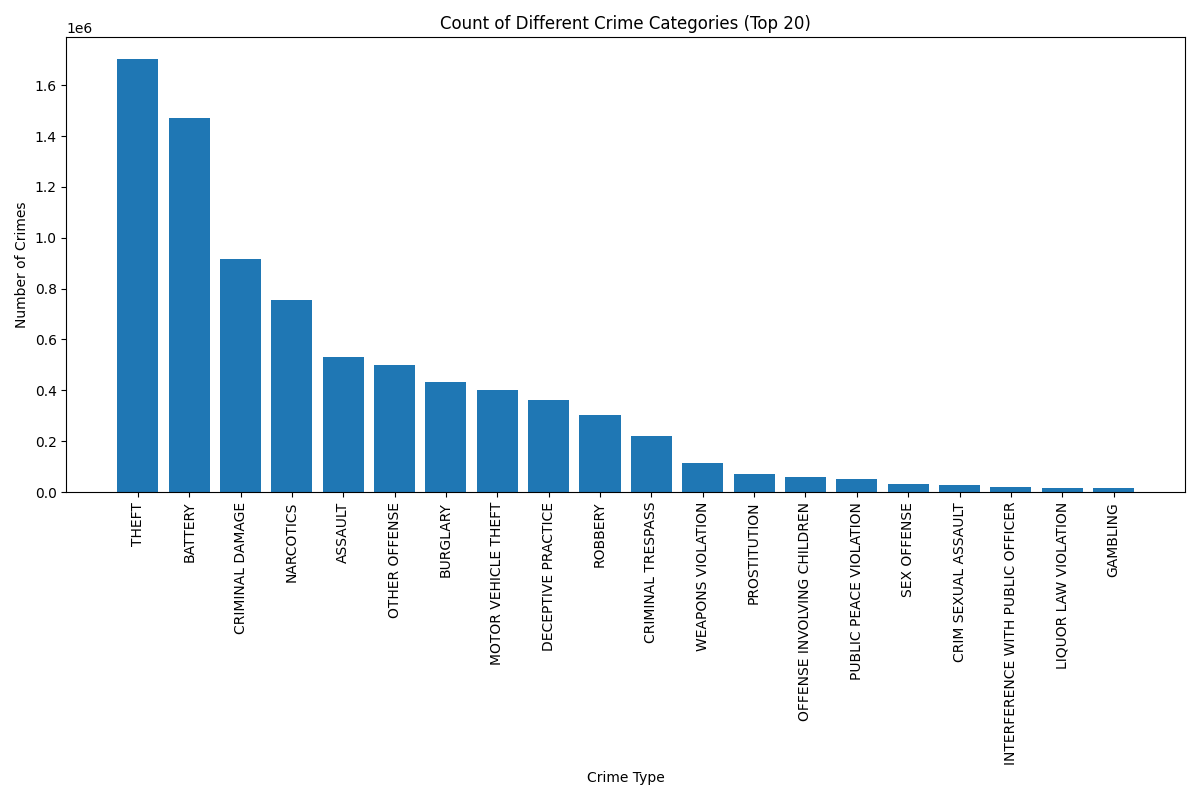

In [37]:
crime_counts = crimes.groupBy("Primary Type").count().orderBy(F.col("count").desc()).limit(20)

crime_counts_pd = crime_counts.toPandas()

plt.figure(figsize=(12, 8))
plt.bar(crime_counts_pd["Primary Type"], crime_counts_pd["count"])
plt.xlabel("Crime Type")
plt.ylabel("Number of Crimes")
plt.title("Count of Different Crime Categories (Top 20)")
plt.xticks(rotation=90)
plt.tight_layout()

%matplot plt

Arrests by crime type

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

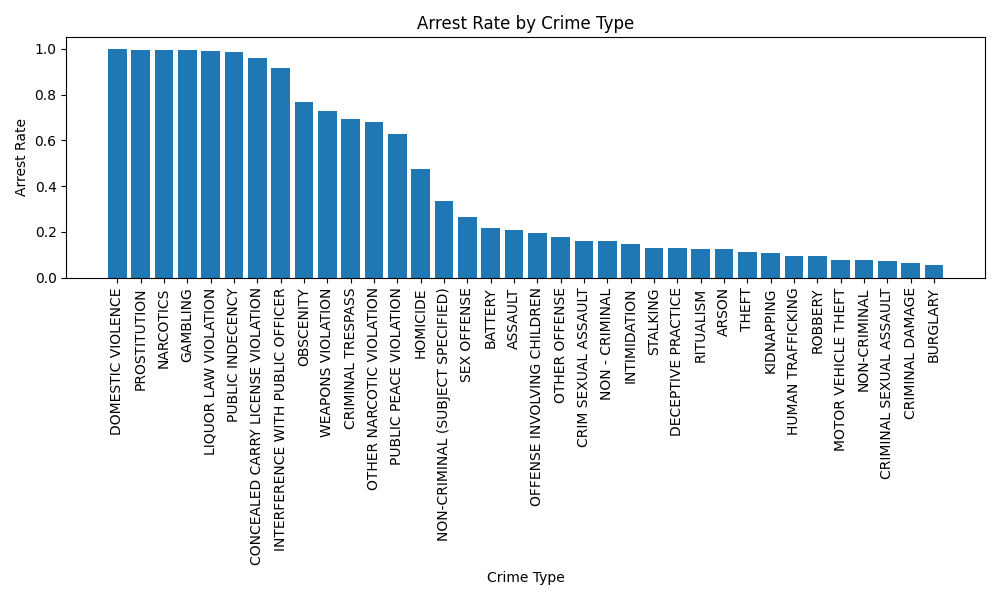

In [25]:
arrest_rates = crimes.groupBy("Primary Type").agg(
    (F.count(F.when(col("Arrest") == True, True)) / F.count("Arrest")).alias("Arrest Rate")
).orderBy("Arrest Rate", ascending=False)

arrest_rates_pd = arrest_rates.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(arrest_rates_pd["Primary Type"], arrest_rates_pd["Arrest Rate"])
plt.xlabel("Crime Type")
plt.ylabel("Arrest Rate")
plt.title("Arrest Rate by Crime Type")
plt.xticks(rotation=90)
plt.tight_layout()

%matplot plt

Top blocks and district for crime

In [26]:
crimes.groupBy("Block").count().orderBy(col("count").desc()).show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------------------+-----+
|Block                              |count|
+-----------------------------------+-----+
|100XX W OHARE ST                   |16688|
|001XX N STATE ST                   |16070|
|076XX S CICERO AVE                 |10361|
|008XX N MICHIGAN AVE               |9563 |
|0000X N STATE ST                   |9551 |
|0000X W TERMINAL ST                |7094 |
|064XX S DR MARTIN LUTHER KING JR DR|6193 |
|063XX S DR MARTIN LUTHER KING JR DR|5761 |
|023XX S STATE ST                   |5284 |
|001XX W 87TH ST                    |4782 |
|006XX N MICHIGAN AVE               |4628 |
|012XX S WABASH AVE                 |4522 |
|0000X S STATE ST                   |4512 |
|057XX S CICERO AVE                 |4498 |
|008XX N STATE ST                   |4446 |
|009XX W BELMONT AVE                |4272 |
|033XX W FILLMORE ST                |4196 |
|022XX S STATE ST                   |4026 |
|075XX S STONY ISLAND AVE           |3980 |
|007XX N MICHIGAN AVE           

In [27]:
crimes.groupBy("District").count().orderBy("count", ascending=False).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+------+
|District| count|
+--------+------+
|       8|541139|
|      11|514904|
|       6|471503|
|       7|461609|
|      25|457651|
|       4|457356|
|       3|408716|
|      12|402253|
|       9|392623|
|       2|382404|
|      19|363958|
|      18|363275|
|       5|356070|
|      10|347064|
|      15|342547|
|       1|329846|
|      14|311187|
|      16|270639|
|      22|263628|
|      24|245270|
+--------+------+
only showing top 20 rows

Arrests in domestic incidents

In [28]:
crimes.filter(col("Domestic") == True).groupBy("Arrest").count().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-------+
|Arrest|  count|
+------+-------+
|  true| 269213|
| false|1116955|
+------+-------+

Its sad to see the lack of arrests in domestic violence cases. 

crime trends over years

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

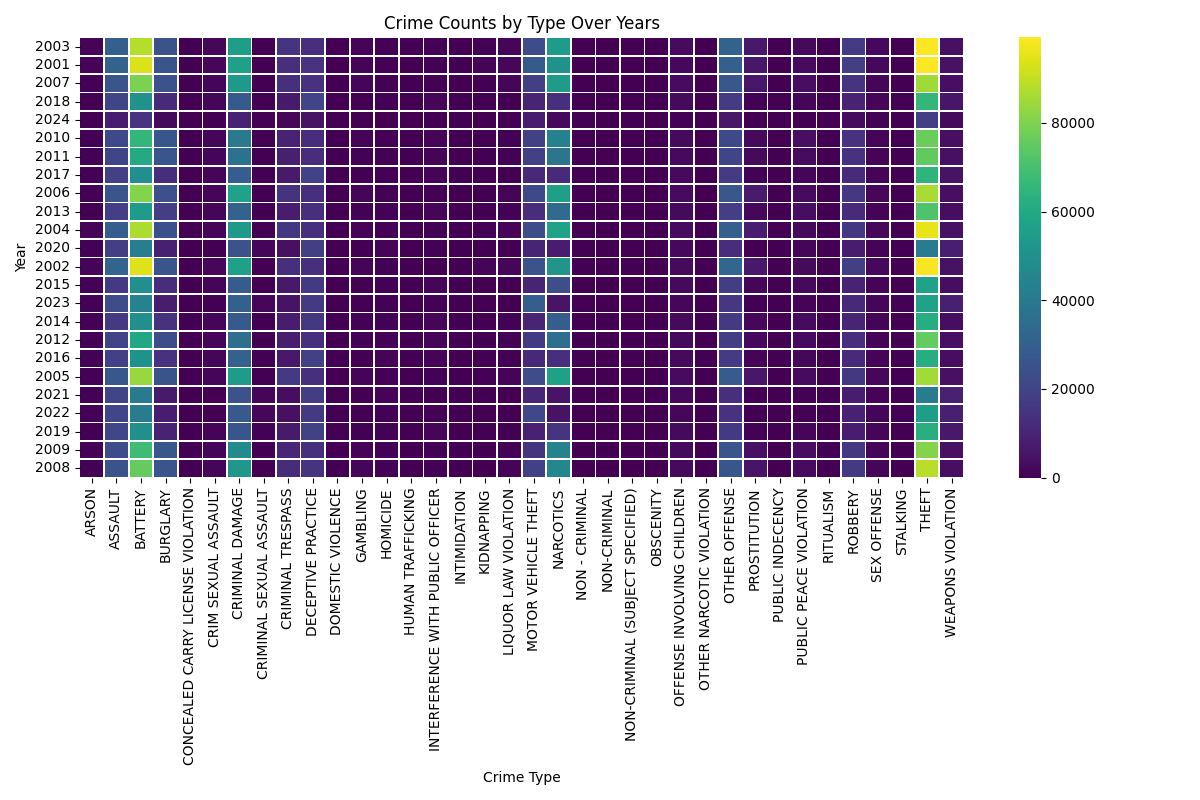

In [29]:
import seaborn as sns
pivoted_data = crimes.groupBy("Year", "Primary Type").count().groupBy("Year").pivot("Primary Type").sum("count")

pivoted_data_pd = pivoted_data.toPandas()

plt.figure(figsize=(12, 8))
sns.heatmap(pivoted_data_pd.set_index('Year').fillna(0), cmap='viridis', linewidths=.5)
plt.title('Crime Counts by Type Over Years')
plt.xlabel('Crime Type')
plt.ylabel('Year')
plt.xticks(rotation=90)
plt.tight_layout()

%matplot plt

Group and count crimes where description begins with the word “aggravated”

In [38]:
agg_crimes = crimes.filter(crimes["Description"].startswith("AGGRAVATED"))

agg_crime_counts = agg_crimes.groupBy("Primary Type").agg(F.count("*").alias("Crime Count"))

agg_crime_counts.show(truncate = False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------+-----------+
|Primary Type              |Crime Count|
+--------------------------+-----------+
|CRIMINAL SEXUAL ASSAULT   |1793       |
|BATTERY                   |216279     |
|SEX OFFENSE               |943        |
|ASSAULT                   |143337     |
|CRIM SEXUAL ASSAULT       |7398       |
|DECEPTIVE PRACTICE        |1188       |
|STALKING                  |154        |
|THEFT                     |1          |
|ROBBERY                   |29866      |
|KIDNAPPING                |458        |
|OFFENSE INVOLVING CHILDREN|3013       |
|ARSON                     |2098       |
+--------------------------+-----------+

Which crime type is the most prevalent in apartments and which community has it occurred the most

In [39]:
apt_crimes = crimes.filter(crimes["Location Description"] == 'APARTMENT')

apt_crimes_count = apt_crimes.groupBy(
    "Primary Type").agg(F.count("*").alias("Crime Count"))

most_prevalent_crime = apt_crimes_count.orderBy(col(
    "Crime Count").desc()).first()
print("Most prevalent crime type in apartments: ", most_prevalent_crime["Primary Type"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Most prevalent crime type in apartments:  BATTERY

In [40]:
most_prevalent_crime_type = most_prevalent_crime["Primary Type"]
most_prevalent_community = apt_crimes.filter(apt_crimes["Primary Type"] == most_prevalent_crime_type) \
    .groupBy("community_name") \
    .agg(F.count("*").alias("Crime Count")) \
    .orderBy(col("Crime Count").desc()) \
    .first()

print("Community with the most occurrences of the most prevalent crime type: ", most_prevalent_community["community_name"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Community with the most occurrences of the most prevalent crime type:  Austin

What percentage of the domestic crimes led to an arrest ?

In [41]:
domestic_crimes = crimes.filter(crimes["Domestic"] == True)

total_domestic_crimes = domestic_crimes.count()

arrested_domestic_crimes = domestic_crimes.filter(domestic_crimes["Arrest"] == True).count()

arrest_percentage = (arrested_domestic_crimes / total_domestic_crimes) * 100

print(f"Percentage of domestic crimes that led to an arrest: {arrest_percentage:.2f}%")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Percentage of domestic crimes that led to an arrest: 19.42%

Exploring data by date and time

Which day of the week and which month have the most and the least crimes on average?

Note: Since we don't have an average, have taken count of crimes. 

In [42]:
crimes_count_day_of_week = crimes.groupBy(F.dayofweek("Date").alias("DayOfWeek")).agg(F.count("*").alias("CrimeCount"))
most_crimes_day = crimes_count_day_of_week.orderBy(col("CrimeCount").desc()).first()
least_crimes_day = crimes_count_day_of_week.orderBy(col("CrimeCount").asc()).first()
print("Day of the week with most crime is", most_crimes_day["DayOfWeek"])
print("Day of the week with least crime is", least_crimes_day["DayOfWeek"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Day of the week with most crime is 6
Day of the week with least crime is 1

In [43]:
crimes_per_month = crimes.groupBy('Month').agg(F.count("*").alias("CrimeCount"))
most_crimes_month = crimes_per_month.orderBy(col("CrimeCount").desc()).first()
least_crimes_month = crimes_per_month.orderBy(col("CrimeCount").asc()).first()
print("Month with most crime is", most_crimes_month["Month"])
print("Month with least crime is", least_crimes_month["Month"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Month with most crime is 7
Month with least crime is 2

Which date had the most number of homicides in the dataset. How many days passed between this date
and the next highest number of homicides

In [44]:
homicide_crimes = crimes.filter(crimes["Primary Type"] == "HOMICIDE")
homicide_crimes = homicide_crimes.withColumn("only_date", F.to_date(col("Date")))
homicide_counts_by_date = homicide_crimes.groupBy("only_date").agg(F.count("*").alias("Homicide Count"))

most_homicides_date = homicide_counts_by_date.orderBy(col("Homicide Count").desc()).first()

next_highest_date = homicide_counts_by_date.filter(col("only_date") != most_homicides_date["only_date"]) \
    .orderBy(col("Homicide Count").desc()).first()
days_difference = (most_homicides_date["only_date"] - next_highest_date["only_date"]).days

print(f"The date with the most homicides is: {most_homicides_date['only_date']}")
print(f"The date with the second most homicides is: {next_highest_date['only_date']}")
print(f"Number of days between the two dates: {days_difference} days")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The date with the most homicides is: 2020-05-31
The date with the second most homicides is: 2003-07-05
Number of days between the two dates: 6175 days

Plot a monthly time series line chart of all crimes for the last 3 years


1. Doing one chart that maps out all crimes as a single time series line over the last 3 years (from April 2021 to April 2024)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

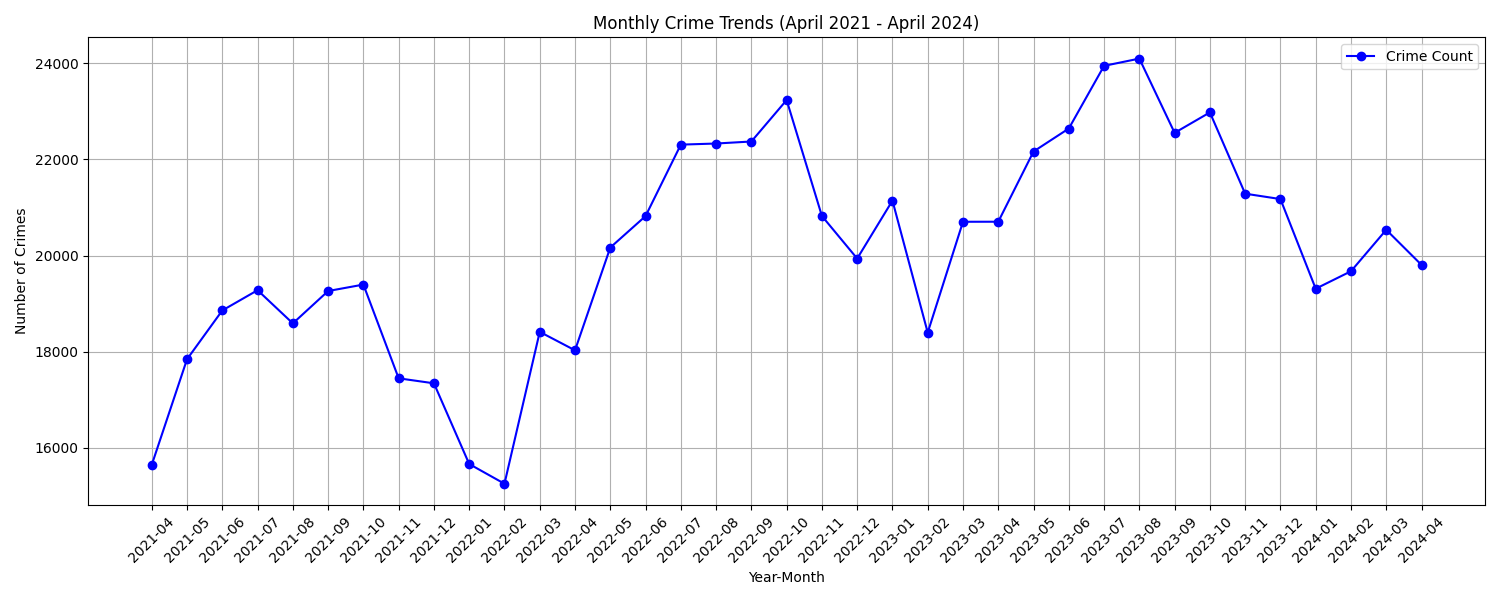

In [48]:
crime_by_month = crimes.groupBy('Year', 'Month').count().orderBy(["Year", "Month"], ascending=[0, 0])

crimes_apr_2021_onwards = crime_by_month.filter((crime_by_month["Year"] > 2021) | (
    (crime_by_month["Year"] == 2021) & (crime_by_month["Month"] >= 4)))
crimes_apr_2021_onwards = crimes_apr_2021_onwards.filter(
    (crime_by_month["Year"] != 2024) | (crime_by_month["Month"] != 5))

pdf = crimes_apr_2021_onwards.toPandas()

pdf = pdf[::-1]

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(pdf["Year"].astype(str) + "-" + pdf["Month"].astype(str).str.zfill(2), pdf["count"], marker='o', linestyle='-', color='b', label='Crime Count')
ax.set_xlabel("Year-Month")
ax.set_ylabel("Number of Crimes")
ax.set_title("Monthly Crime Trends (April 2021 - April 2024)")

ax.set_xticks(range(len(pdf.index)))
ax.set_xticklabels(pdf["Year"].astype(str) + "-" + pdf["Month"].astype(str).str.zfill(2), rotation=45)
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

%matplot plt

2. Doing another chart where grouping by month, and doing crime counts per month over the last 3 years (2021,2022,2023). 

In [49]:
# Filter the data for the years 2020, 2021, and 2022
filtered_crimes = crimes.filter((crimes["Year"] >= 2021) & (crimes["Year"] <= 2023))
filtered_crimes = filtered_crimes.groupBy("Primary Type").pivot("Year").count()
# Limit the DataFrame to the top 5 rows
filtered_crimes_2021 = filtered_crimes.orderBy(col("2021").desc()).limit(5)
filtered_crimes_2021.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+-----+-----+
|      Primary Type| 2021| 2022| 2023|
+------------------+-----+-----+-----+
|             THEFT|40809|54874|57366|
|           BATTERY|40466|40936|44173|
|   CRIMINAL DAMAGE|25096|27245|30065|
|           ASSAULT|20343|20807|22604|
|DECEPTIVE PRACTICE|17654|16726|16825|
+------------------+-----+-----+-----+

Calculate the community rank based on total crime figures (highest to lowest),
where the community with the highest crime will have rank 1.

In [50]:
crime_counts = crimes.groupBy("community_name").agg(F.count("*").alias("total_crime_count"))

# removing crimes where community_name is not there, otherwise Null is the top rank
crime_counts = crime_counts.filter(crime_counts["community_name"].isNotNull())
window_spec = Window.orderBy(F.desc("total_crime_count"))

ranked_communities = crime_counts.withColumn("rank", F.rank().over(window_spec))
result = ranked_communities.select("rank","community_name", "total_crime_count")

result.show(78)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------------------+-----------------+
|rank|      community_name|total_crime_count|
+----+--------------------+-----------------+
|   1|              Austin|           461597|
|   2|     Near North Side|           264554|
|   3|         South Shore|           245455|
|   4|       Humboldt Park|           231467|
|   5|      Near West Side|           227959|
|   6|           West Town|           218531|
|   7|      North Lawndale|           217182|
|   8|      Auburn Gresham|           210313|
|   9|      West Englewood|           210045|
|  10|            Roseland|           196920|
|  11|           Englewood|           192444|
|  12|            The Loop|           187110|
|  13|Greater Grand Cro...|           185230|
|  14|        Chicago Lawn|           180137|
|  15|             Chatham|           164586|
|  16|        Logan Square|           153872|
|  17|           Lake View|           151835|
|  18|            New City|           148925|
|  19|  West Garfield Park|       

Use a window function to calculate a rolling 7 day sum of crimes over time within each community

Making an assumption that we only have to look at days where a crime was actually committed. So, each and every day for each community in all these years might not be there in the dataset. 

In [51]:
daily_crimes = crimes.withColumn("only_date", F.to_date(col("Date")))

daily_crime_count = daily_crimes.groupBy("community_name", "only_date").count()
window_spec = Window.partitionBy("community_name").orderBy("only_date").rangeBetween(0, 7 * 86400)

rolling_7day_sum = daily_crime_count.withColumn("rolling_7day_sum",
    F.sum("count").over(window_spec.rowsBetween(-6, 0))
)

rolling_7day_sum = rolling_7day_sum.filter(crime_counts["community_name"].isNotNull())
result = rolling_7day_sum.select("community_name", "only_date", "rolling_7day_sum").orderBy("only_date")

result.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+----------+----------------+
|    community_name| only_date|rolling_7day_sum|
+------------------+----------+----------------+
|   Calumet Heights|2001-01-01|               1|
|       Morgan Park|2001-01-01|               1|
|Washington Heights|2001-01-01|               3|
|          Woodlawn|2001-01-01|               4|
|         Englewood|2001-01-01|               6|
|    Jefferson Park|2001-01-01|               1|
|     Humboldt Park|2001-01-01|              20|
|           Chatham|2001-01-01|               5|
|    North Lawndale|2001-01-01|              43|
|East Garfield Park|2001-01-01|               9|
|         Lake View|2001-01-01|               2|
|           Ashburn|2001-01-01|               4|
|         West Lawn|2001-01-01|               1|
|        West Ridge|2001-01-01|               1|
|   Near South Side|2001-01-01|               2|
|        North Park|2001-01-01|               2|
|    Near West Side|2001-01-01|               8|
|       Forest Glen|

Use window functions to calculate a 7 day moving average and cumulative sum of crimes over time within each community. Your results set should have 4 columns: community, date, the 7 day moving average, and the cumulative sum.

Source used: https://stackoverflow.com/questions/45806194/pyspark-rolling-average-using-timeseries-data

In [52]:
daily_crimes = crimes.withColumn("only_date", F.to_date(col("Date")))

daily_crime_count = daily_crimes.groupBy("community_name", "only_date").count()

daily_crime_count = daily_crime_count.withColumn("timestamp_date", F.unix_timestamp("only_date"))

window_spec = Window.partitionBy("community_name").orderBy("timestamp_date").rangeBetween(0, 7 * 86400)

daily_crime_count = daily_crime_count.withColumn("7_day_moving_avg", F.avg("count").over(window_spec.rowsBetween(-6, 0)))
daily_crime_count = daily_crime_count.withColumn("cumulative_sum", F.sum("count").over(window_spec))

daily_crime_count = daily_crime_count.filter(
    daily_crime_count["community_name"].isNotNull())

result = daily_crime_count.select(
    "community_name", "only_date", "7_day_moving_avg", "cumulative_sum").orderBy('only_date')
result.show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+----------+----------------+--------------+
|    community_name| only_date|7_day_moving_avg|cumulative_sum|
+------------------+----------+----------------+--------------+
|           Kenwood|2001-01-01|             2.0|             2|
|        North Park|2001-01-01|             2.0|             3|
|         West Lawn|2001-01-01|             1.0|             1|
|   Near South Side|2001-01-01|             2.0|             3|
|           Ashburn|2001-01-01|             4.0|             4|
|    Near West Side|2001-01-01|             8.0|             9|
|          Woodlawn|2001-01-01|             4.0|             4|
|East Garfield Park|2001-01-01|             9.0|            10|
|    North Lawndale|2001-01-01|            43.0|            44|
|         Lake View|2001-01-01|             2.0|             2|
|       Morgan Park|2001-01-01|             1.0|             1|
|   Lower West Side|2001-01-01|             3.0|             4|
|        West Ridge|2001-01-01|         

Cross-tabulate Crime Types vs Location description and visualizing it through a heatmap

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

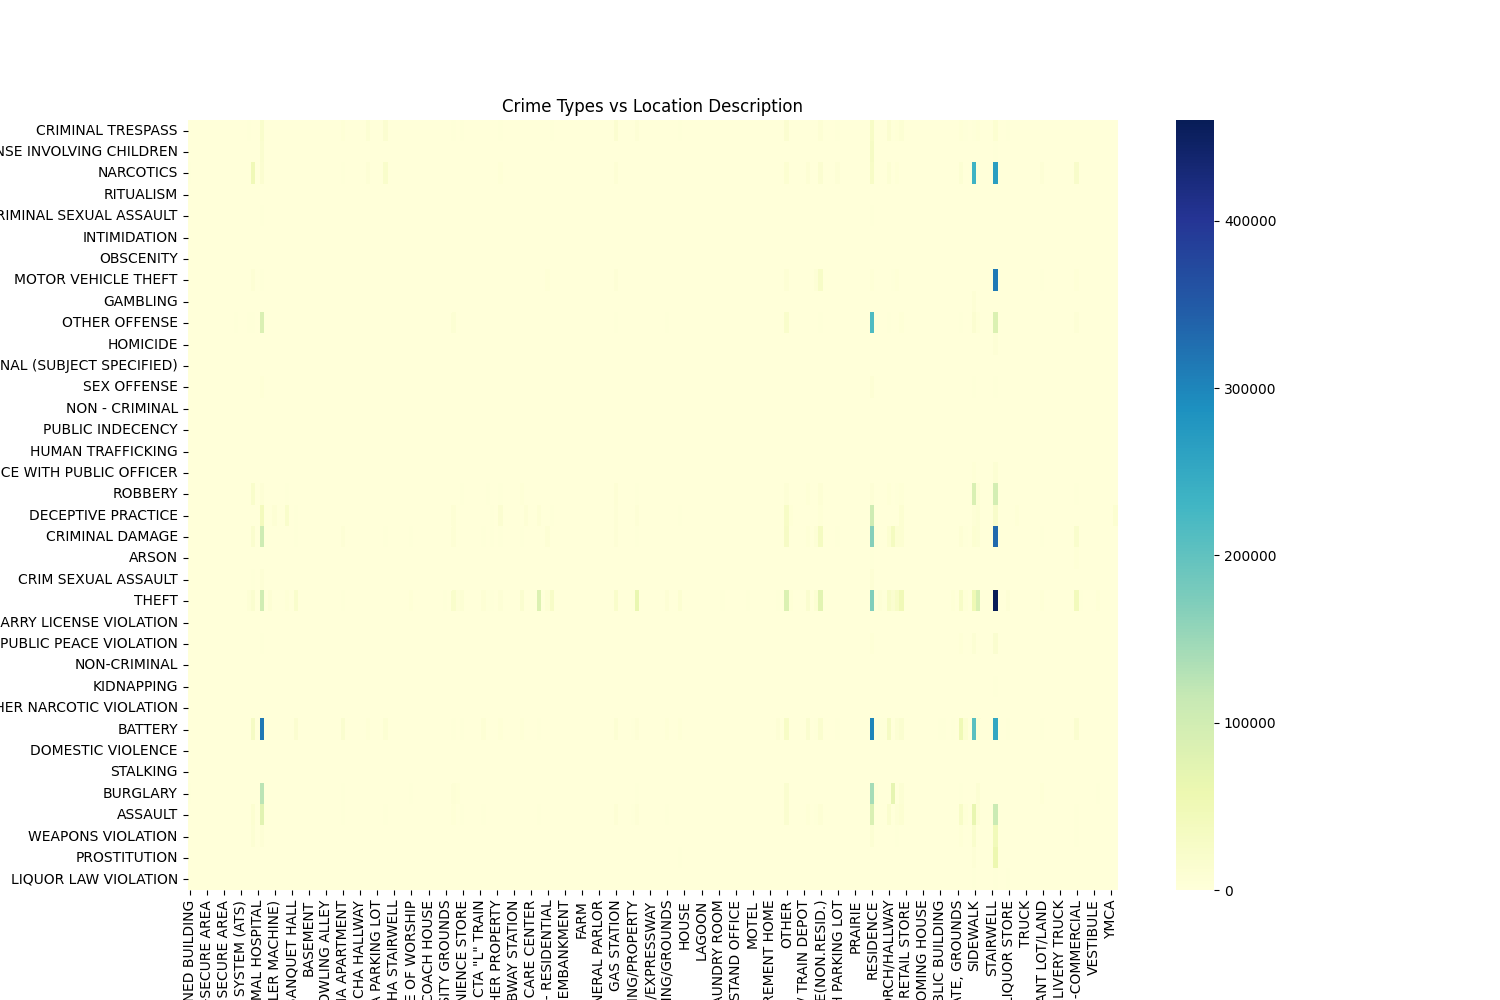

In [47]:
import seaborn as sns

crime_location_cross_tab = crimes.crosstab("Primary Type", "Location Description")

pd_cross_tab = crime_location_cross_tab.toPandas()

plt.figure(figsize=(15, 10))

sns.heatmap(pd_cross_tab.set_index("Primary Type_Location Description"),
            cmap="YlGnBu", annot=False, fmt="d")
plt.title("Crime Types vs Location Description")
plt.xlabel("Location Description")
plt.ylabel("Crime Type")
plt.show()
%matplot plt

## Adding in socio-economic indicators by community

To gain better profiles of the Chicago constituents who may be affected by the crime, general socio-economic factors including Poverty Level, unemployment, no High School Diploma and per Capita Income will be considered. Information was obtained from Public health Data by Community Area portal. Note it is the average over the three-year period (2019-2022). 

In [53]:
socio_economic_indicators = spark.read \
    .option("quote", "\"")  \
    .option("escape", "\"") \
    .option("ignoreLeadingWhiteSpace",True) \
    .csv("s3://hvpachisia-chicago-crime/raw_data/Public_Health_Statistics_-_Selected_public_health_indicators_by_Chicago_community_area_-_Historical_20240522.csv",inferSchema=True, header=True )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
socio_economic_indicators.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- Community Area: integer (nullable = true)
 |-- Community Area Name: string (nullable = true)
 |-- Birth Rate: double (nullable = true)
 |-- General Fertility Rate: double (nullable = true)
 |-- Low Birth Weight: double (nullable = true)
 |-- Prenatal Care Beginning in First Trimester: double (nullable = true)
 |-- Preterm Births: double (nullable = true)
 |-- Teen Birth Rate: double (nullable = true)
 |-- Assault (Homicide): double (nullable = true)
 |-- Breast cancer in females: double (nullable = true)
 |-- Cancer (All Sites): double (nullable = true)
 |-- Colorectal Cancer: double (nullable = true)
 |-- Diabetes-related: double (nullable = true)
 |-- Firearm-related: double (nullable = true)
 |-- Infant Mortality Rate: double (nullable = true)
 |-- Lung Cancer: double (nullable = true)
 |-- Prostate Cancer in Males: double (nullable = true)
 |-- Stroke (Cerebrovascular Disease): double (nullable = true)
 |-- Childhood Blood Lead Level Screening: double (nullable = true)
 |

Below we are enriching the crimes dataframe with the socio-economic factors including % below poverty level, % with no High-School Diploma, per Capita Income and unemployment rate. This was done using an inner join. 

In [55]:
crimes = crimes.withColumnRenamed("Community Area", "community_area")
socio_economic_indicators = socio_economic_indicators.withColumnRenamed("Community Area", "community_area")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
crimes = crimes.join(socio_economic_indicators,"community_area",'inner')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
crimes = crimes.drop("Community Area Name", "General Fertility Rate", "Low Birth Weight"
                    ,"Prenatal Care Beginning in First Trimester","Preterm Births",
                    "Teen Birth Rate","Breast cancer in females","Cancer (All Sites)",
                    "Colorectal Cancer","Diabetes-related","Firearm-related","Infant Mortality Rate",
                    "Lung Cancer","Prostate Cancer in Males","Stroke (Cerebrovascular Disease)",
                    "Childhood Blood Lead Level Screening","Childhood Lead Poisoning",
                    "Gonorrhea in Females","Gonorrhea in Males","Tuberculosis",
                    "Dependency")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
crimes = crimes.drop('assault_(homicide)')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [59]:
crimes.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- community_area: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- community_name: string (nullable = true)
 |-- Birth Rate: double (nullable = true)
 |-- Assau

In [ ]:
output_path = "s3://hvpachisia-chicago-crime/data_after_eda/"

crimes.write.option("header", "true") \
    .csv(output_path, mode="overwrite")